## Overview of what all we have done until now

# Short-term synaptic plasticity

Changes in synaptic efficacy over time as a function of presynaptic activity.

## Two types of STP:

* **Short-term depression (STD)**: Caused by depletion of neurotransmitters during the process of synaptic signaling at the axon terminal of a pre-synaptic neuron.

* **Short-term facilitation (STF)  
**: Caused by influx of $Ca^{2+}$ into the axon terminal after spike generation, which increases the release probability of neurotransmitters.

## Modeling short term synaptic plasticity

 [ *Misha Tsodyks and Si Wu (2013), Scholarpedia, 8(10):3153* ]

* **STD** effect is modeled by a normalized variable $ x \in [0,1]$, fraction of resources that remain available after neurotransmitter depletion. 

* The **STF** effect is modeled by a utilization parameter $u \in [0,U]$, representing the fraction of available resources ready for use (**release probability**). 

Thus, following a spike, 
1. $u$ increases due to spike-induced calcium influx to the presynaptic terminal, after which 
2. A fraction $u$ of available resources is consumed to produce the post-synaptic current. 
3. Between spikes, $u$ decays back to zero with time constant $τ_f$ and $x$ recovers to $1$ with time constant $τ_d$.

$$
\begin{aligned}
\frac{du}{dt} = -\frac{u}{\tau_f} + U(1-u^-)\delta(t-t_{sp}) \\
\frac{dx}{dt} = \frac{1-x}{\tau_d} - u^+x^ -\delta(t-t_{sp}) \\
\frac{dI}{dt} = -\frac{I}{\tau_s} + Au^+x^ -\delta(t-t_{sp}), \\
\end{aligned}
$$

$t_{sp}$: time of spike,
$U$: increment of $u$ produced by a spike.
$u^−, x^- \& u^+ $ corresponding variables just before the arrival and the moment just after the spike respectively.

From the first equation, $u^+=u^− + U(1 − u^−)$. The synaptic current generated at the synapse by the spike arriving at $t_{sp}$ is then given by $ ΔI(t_{sp}) = A u^+ x^− $

$A$ : Absolute synaptic efficacy, or the response amplitude that would be produced by total release of all the neurotransmitter ($u=x=1$).

## Now let's model it with Brian.

In [1]:
%matplotlib inline
from brian2 import *

## Number of input and output neurons
N = 10

eqs = '''
dpreVolt/dt=r : 1
r : Hz
'''
spikingNeurons = NeuronGroup(N, model=eqs, threshold='preVolt>1.', reset='preVolt=0.')
spikingNeurons.r = linspace(5 * Hz, 30 * Hz, N)

#store()
#input_spikes = SpikeMonitor(spikingNeurons)
#run(1000 * ms)
#plot(input_spikes.t, input_spikes.i, '|k')
#xlabel('Time (ms)')
#ylabel('Neuron index')
#show()
#restore()

/usr/local/lib/python2.7/dist-packages/brian2/core/variables.py:174: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  return np.issubdtype(np.bool, self.dtype)
WARNING    /usr/local/lib/python2.7/dist-packages/brian2/core/variables.py:174: FutureWarning: Conversion of the second argument of issubdtype from `bool` to `np.generic` is deprecated. In future, it will be treated as `np.bool_ == np.dtype(bool).type`.
  return np.issubdtype(np.bool, self.dtype)
 [py.warnings]


In [2]:
## Let us initialize variables for the output neurons.

tau_s = 3 * ms # Decay current
tau_m = 10 * ms # Decay of membrane potential
Rm = 100 * Mohm # Membrane resistance

eqs_neuron = '''
dv/dt=(Rm*I-v)/tau_m:volt
dI/dt=-I/tau_s:amp
'''
outputNeurons = NeuronGroup(N, model=eqs_neuron)

In [3]:
## Let's put synapses between these groups of neurons.

A_SE = 250 * pA # Absolute synaptic efficacy

taud=100*ms # Decay time synaptic depression
tauf=10*ms # Decay time synaptic facilitation
U=.2 # Release probability

In [4]:
S=Synapses(spikingNeurons, outputNeurons,
           model='''w : amp
                    dx/dt=(1-x)/taud : 1
                    du/dt=(-u)/tauf : 1
                 ''',
           on_pre=''' u+=U*(1-u)
                  I+=w*u*x
                  x-= x*u''')

S.connect('i==j') # one to one connection
S.w=A_SE # Initializing synaptic weights to absolute synaptic efficacy

# Initialization of STP variables

S.x = 1 # Fraction of resources that remain available after neurotransmitter depletion 
S.u = U # Fraction of available resources ready for use (release probability)

INFO       The synaptic equation for the variable x does not specify whether it should be integrated at every timestep ("clock-driven") or only at spiking events ("event-driven"). It will be integrated at every timestep which can slow down your simulation unnecessarily if you only need the values of this variable whenever a spike occurs. Specify the equation as clock-driven explicitly to avoid this warning. [brian2.synapses.synapses.clock_driven]
INFO       The synaptic equation for the variable u does not specify whether it should be integrated at every timestep ("clock-driven") or only at spiking events ("event-driven"). It will be integrated at every timestep which can slow down your simulation unnecessarily if you only need the values of this variable whenever a spike occurs. Specify the equation as clock-driven explicitly to avoid this warning. [brian2.synapses.synapses.clock_driven]


INFO       No numerical integration method specified for group 'neurongroup_1', using method 'exact' (took 0.28s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'neurongroup', using method 'euler' (took 0.02s, trying other methods took 0.00s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses', using method 'exact' (took 0.22s). [brian2.stateupdaters.base.method_choice]


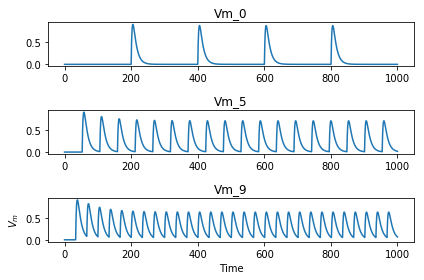

In [5]:
## Setting up monitors
recordingNeurons = [0, N/2, N - 1]
trace = StateMonitor(outputNeurons, 'v', record=recordingNeurons)
u_vals = StateMonitor(S, 'u', record=recordingNeurons)
x_vals = StateMonitor(S, 'x', record=recordingNeurons)

#monitors = [trace, u_vals, x_vals]
#net = Network(collect())  # automatically include G and S
#net.add(monitors)  # manually add the monitors

run(1000 * ms)

for i, index in enumerate(recordingNeurons):
    subplot(3,1,i+1)
    plot(trace.t/ms, trace.v[i] / mV)
    title('Vm_' + str(index))
xlabel("Time")
ylabel("$V_m$")
tight_layout()
show()

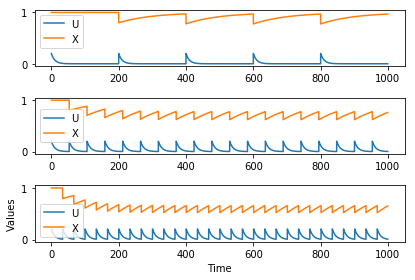

In [6]:
for i, index in enumerate(recordingNeurons):
    subplot(3,1,i+1)
    plot(u_vals.t / ms, u_vals.u[i], label = 'U')
    plot(x_vals.t / ms, x_vals.x[i], label = 'X')
    legend()
xlabel("Time")
ylabel("Values")
tight_layout()
show()

### Can you find when facilitating synapses change to depressing?